In [1]:
%load_ext autoreload
%autoreload 2 

In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from enum import IntEnum
from tqdm import trange, tqdm
from collections import defaultdict
from pvlib.iotools import read_surfrad

from GrU_nn import neuralGrU
from GrU import (evaluate, GrU)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

### Load auction data

In [72]:
class clock( IntEnum ):
    pv = 0
    storage = 1
    charge = 2
    discharge = 3

class source( IntEnum ):
    grid =  0
    pv = 1
    storage = 2
    charge = 3
    discharge = 4

df_auctioneer_data = pd.read_csv('../data/Auctioneer Data.csv')

headers = np.load(file='../data/clock_data_columns.npy', allow_pickle=True)
df_clock_data = pd.DataFrame(np.load('../data/clock_data_values.npy', allow_pickle=True), columns=headers)

def getPriceVectors(round):
    '''
    Get price vectors for a round from the clock data.

    Parameters
    ----------
    round : int
        Round number to get the price vectors for, range = [0, 308]

    Returns
    -------
    prices : ndarray of shape (5, 24)
        Price vectors for g, p, s, c, d.
    
    '''
    prices = np.ndarray((5, 24))
    prices[0] = df_auctioneer_data.GRID_PRICE.values
    for e in clock:
        prices[e + 1] = df_clock_data[f'price_{round}'][e]
    return prices

## Grid Price

### Shift Grid Prices

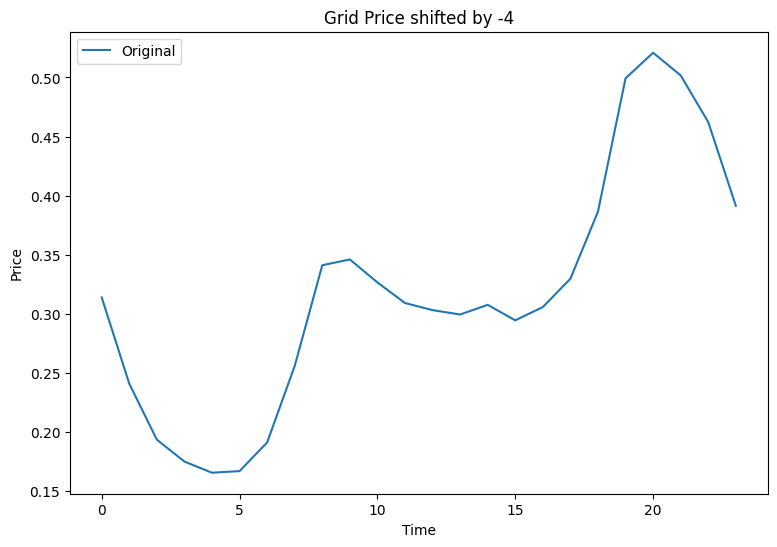

In [142]:
pi_g = getPriceVectors(100)[0]
pi_g_shifted = np.roll(pi_g, shift=-4)

plt.figure(figsize=(9,6))
plt.title('Grid Price shifted by -4')
plt.plot(pi_g, label='Original')
# plt.plot(pi_g_shifted, label='Shifted')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()


In [144]:
# EI values
ep = [0.00044688, 0.00044796, 0.00045042, 0.00045573, 0.00046029, 0.00046002, 0.00045153, 0.00043737, 0.00042772, 0.00041107, 0.00040774, 0.00038668, 0.00037268, 0.00036565, 0.00036387, 0.00035763, 0.00034319, 0.00034377, 0.00035285, 0.00037902, 0.00039631, 0.00040366, 0.00039713, 0.00039088]
ep = np.array(ep) * 1e3

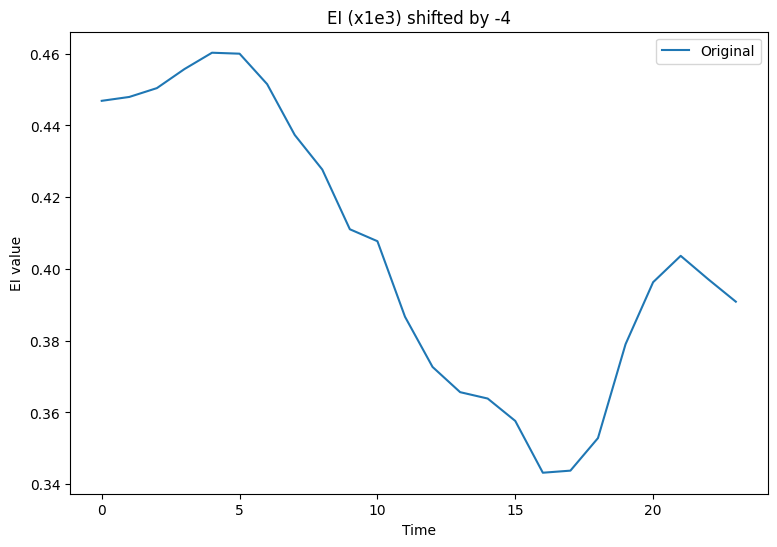

In [145]:
ep_shifted = np.roll(ep, shift=-4)

plt.figure(figsize=(9,6))
plt.title('EI (x1e3) shifted by -4')
plt.plot(ep, label='Original')
# plt.plot(ep_shifted, label='Shifted')
plt.ylabel('EI value')
plt.xlabel('Time')
plt.legend()
plt.show()

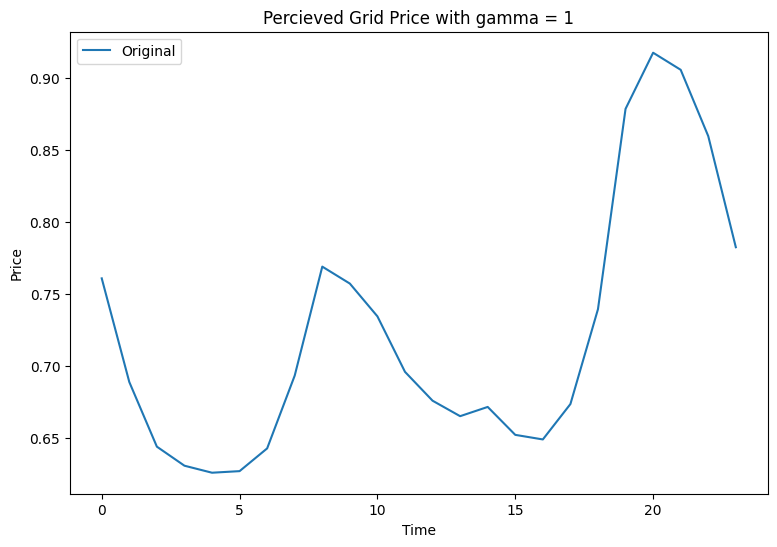

In [146]:
gamma = 1
cost = pi_g + ep * gamma
cost_shifted = pi_g_shifted + ep_shifted * gamma

plt.figure(figsize=(9,6))
plt.title(f'Percieved Grid Price with gamma = {gamma}')
plt.plot( cost, label='Original')
# plt.plot( cost_shifted, label='Shifted' )
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()

### Non-Linear Min-Max Scaling

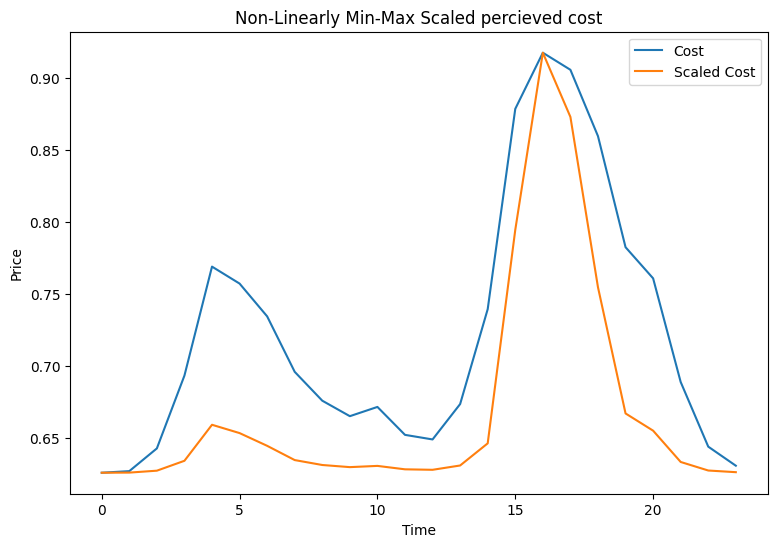

In [30]:
def squash( a, scale = 2 ):
    m = min( a )
    M = max( a )

    p = np.exp( -scale )
    P = np.exp( scale )

    n = (a - m)/(M-m) * 2 * scale
    n = np.exp( n - scale )

    return (n - p) / (P - p) * (M - m) + m

plt.figure(figsize=(9,6))
plt.title('Non-Linearly Min-Max Scaled percieved cost')
plt.plot( cost_shifted, label='Cost' )
plt.plot( squash( cost_shifted, scale = 2 ), label='Scaled Cost' )
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()

# Demand breakup on Shifted & Scaled Grid Prices

In [73]:
eta = 1
B = 1e3
alpha = 1e3
n_agents = 1
ep = np.ones(24)

# model = neuralGrU(B, n_agents, ep, [0], device, eta, eta)

In [74]:
print(source)

<enum 'source'>


In [75]:
prices = getPriceVectors(100)
d_total = np.ones(24) * 2

d_old, _ = GrU(d_total, prices, eta_c=eta, eta_d=eta)

prices = np.roll(prices, shift=-4, axis=1)

prices[source.grid] = squash(prices[source.grid], scale=2)
d_new, _ = GrU(d_total, prices, eta_c=eta, eta_d=eta)

In [76]:
d_old

array([[ 2.,  2., 36.,  2.,  2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 34., 34., 34., 34., 34., 32., 30., 28., 26., 24., 22.,
        20., 18., 16., 14., 12., 10.,  8.,  6.,  4.,  2.,  0.],
       [ 0.,  0., 34.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.]])

In [77]:
d_new

array([[ 2.,  2.,  2.,  6.,  0.,  0.,  2.,  2.,  2.,  2.,  2.,  2., 14.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  4.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.,
        12., 10.,  8.,  6.,  4.,  2.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  2.,  2.,  2.,  2.,  2.,  0.,  0.,  0.,  0.]])

## Daily Surface Radiation data

### Data extraction
- [Reference] https://github.com/sgautam666/Time_Series_Forecasting_of_Solar_Irradiance
- [Dataset] https://gml.noaa.gov/aftp/data/radiation/surfrad/

In [120]:
from ftplib import FTP
from pathlib import Path

yr_list = [2020]
locations = ['Bondville_IL']

for year in yr_list:
    for location in locations:
        source = f"data/radiation/surfrad/{location}/{year}"
        destination = f"../data/NOAA/surfrad/{location}/{year}/"

        ftp = FTP("ftp.gml.noaa.gov")
        ftp.login()
        ftp.cwd(source)
        #ftp.retrlines('LIST') Enable to view what is inside the server

        ftp.nlst()

        # Get all the files
        files = ftp.nlst()

        print("Downloading dataset")
        for file in tqdm(files[150: 200]):
            ftp.retrbinary(f'RETR {file}', open(str(Path(destination) / file), 'wb').write)

        ftp.close()
        print('\nftp connection is now closed')

100%|██████████| 50/50 [02:42<00:00,  3.25s/it]


ftp connection is now closed


In [121]:
columns_list = ['year', 'jday', 'month', 'day', 'hour', 'min', 'dt', 'zen', 'dw_solar', 'uw_solar', 'direct_n', 'diffuse', 'dw_ir', 
           'dw_casetemp', 'dw_dometemp', 'uw_irl', 'uw_casetemp', 'uw_dometemp', 'uvb', 'par', 'netsolar', 'netir', 
           'totalnet', 'temp', 'rh', 'windspd', 'winddir', 'pressure']

In [122]:
dir = '../data/NOAA/surfrad/Bondville_IL/2020'
files = glob.glob(dir + "/*.dat")

df_list = []
for file in files:
    try:
        df, _ = read_surfrad(file, map_variables=True)
        df_list.append(df)
    except: pass

df_solar_data = pd.concat(df_list, axis=0, ignore_index=True)
df_solar_data.shape

(72000, 48)

In [123]:
df_solar_data.sample(10)

,year,jday,month,day,hour,minute,dt,solar_zenith,ghi,ghi_flag,...,temp_air,temp_air_flag,relative_humidity,relative_humidity_flag,wind_speed,wind_speed_flag,wind_direction,wind_direction_flag,pressure,pressure_flag
21496,2020,200,7,18,22,16,22.267,57.08,506.7,0,...,30.7,0,65.5,0,5.8,0,194.8,0,988.5,0
71955,2020,196,7,14,23,15,23.250,67.96,400.3,0,...,27.6,0,57.6,0,1.8,0,154.0,0,990.4,0
68452,2020,159,6,7,12,52,12.867,64.54,349.3,0,...,18.4,0,57.8,0,NaN,1,NaN,1,992.9,0
15251,2020,177,6,25,14,11,14.183,49.92,621.0,0,...,24.3,0,57.2,0,NaN,1,NaN,1,991.1,0
64753,2020,161,6,9,23,13,23.217,67.92,51.4,0,...,27.2,0,79.7,0,NaN,1,NaN,1,974.4,0
24594,2020,168,6,16,1,54,1.900,95.42,-2.0,0,...,23.2,0,40.0,0,NaN,1,NaN,1,999.8,0
13307,2020,166,6,14,5,47,5.783,116.64,-1.4,0,...,18.1,0,55.4,0,NaN,1,NaN,1,998.4,0
56905,2020,156,6,4,12,25,12.417,69.67,206.8,0,...,20.1,0,88.2,0,NaN,1,NaN,1,984.2,0
17647,2020,180,6,28,6,7,6.117,116.66,-1.2,0,...,20.9,0,93.6,0,NaN,1,NaN,1,983.9,0
16530,2020,182,6,30,11,30,11.500,80.26,95.4,0,...,22.7,0,82.8,0,5.0,0,149.2,0,987.9,0


In [125]:
cols_to_drop = ['ghi_flag', 'uw_solar_flag', 
                'dni_flag', 'dhi_flag', 'dw_ir_flag', 'dw_casetemp', 'dw_casetemp_flag', 
                'dw_dometemp', 'dw_dometemp_flag', 'uw_ir_flag', 'uw_casetemp', 'uw_casetemp_flag', 
                'uw_dometemp', 'uw_dometemp_flag', 'uvb_flag', 'par_flag', 'netsolar_flag', 'netir_flag', 
                'totalnet_flag', 'temp_air_flag', 'relative_humidity_flag', 'wind_speed', 
                'wind_speed_flag', 'wind_direction', 'wind_direction_flag', 'pressure_flag']

df_solar_data = df_solar_data.drop(columns = cols_to_drop)
df_solar_data.head()

,year,jday,month,day,hour,minute,dt,solar_zenith,ghi,uw_solar,...,dw_ir,uw_ir,uvb,par,netsolar,netir,totalnet,temp_air,relative_humidity,pressure
0,2020,160,6,8,0,0,0.000,76.72,157.0,48.7,...,382.6,452.4,8.9,71.5,123.0,-69.8,53.2,29.0,31.2,989.8
1,2020,160,6,8,0,1,0.017,76.90,154.1,47.9,...,382.4,451.8,8.7,70.2,120.9,-69.4,51.4,28.9,31.4,989.8
2,2020,160,6,8,0,2,0.033,77.08,151.2,47.1,...,382.5,451.8,8.4,69.0,117.1,-69.3,47.8,28.9,31.2,989.8
3,2020,160,6,8,0,3,0.050,77.26,148.4,46.3,...,382.4,451.6,8.2,67.7,116.5,-69.2,47.3,28.9,31.1,989.8
4,2020,160,6,8,0,4,0.067,77.44,145.6,45.5,...,382.3,451.7,8.0,66.5,114.5,-69.4,45.1,28.9,30.9,989.8


In [126]:
def format_index(data):
    """Create UTC localized DatetimeIndex for the dataframe.
    Parameters
    ----------
    data: Dataframe
        Must contain columns 'year', 'jday', 'hour' and
        'minute'.
    Return
    ------
    data: Dataframe
        Dataframe with a DatetimeIndex localized to UTC.
    """
    year = data.year.apply(str)
    jday = data.jday.apply(lambda x: '{:03d}'.format(x))
    hours = data.hour.apply(lambda x: '{:02d}'.format(x))
    minutes = data.minute.apply(lambda x: '{:02d}'.format(x))
    index = pd.to_datetime(year + jday + hours + minutes, format="%Y%j%H%M")
    data.index = index
    data = data.tz_localize('UTC')
    return data

In [127]:
df = format_index(df_solar_data)
df.drop(columns=['year', 'month', 'day', 'minute', 'dt'], inplace=True)

In [128]:
df.index.hour

Int64Index([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            ...
            23, 23, 23, 23, 23, 23, 23, 23, 23, 23],
           dtype='int64', length=72000)

In [129]:
df.head()

,jday,hour,solar_zenith,ghi,uw_solar,dni,dhi,dw_ir,uw_ir,uvb,par,netsolar,netir,totalnet,temp_air,relative_humidity,pressure
2020-06-08 00:00:00+00:00,160,0,76.72,157.0,48.7,523.7,51.4,382.6,452.4,8.9,71.5,123.0,-69.8,53.2,29.0,31.2,989.8
2020-06-08 00:01:00+00:00,160,0,76.90,154.1,47.9,520.0,50.9,382.4,451.8,8.7,70.2,120.9,-69.4,51.4,28.9,31.4,989.8
2020-06-08 00:02:00+00:00,160,0,77.08,151.2,47.1,516.0,48.8,382.5,451.8,8.4,69.0,117.1,-69.3,47.8,28.9,31.2,989.8
2020-06-08 00:03:00+00:00,160,0,77.26,148.4,46.3,512.0,49.9,382.4,451.6,8.2,67.7,116.5,-69.2,47.3,28.9,31.1,989.8
2020-06-08 00:04:00+00:00,160,0,77.44,145.6,45.5,508.0,49.5,382.3,451.7,8.0,66.5,114.5,-69.4,45.1,28.9,30.9,989.8


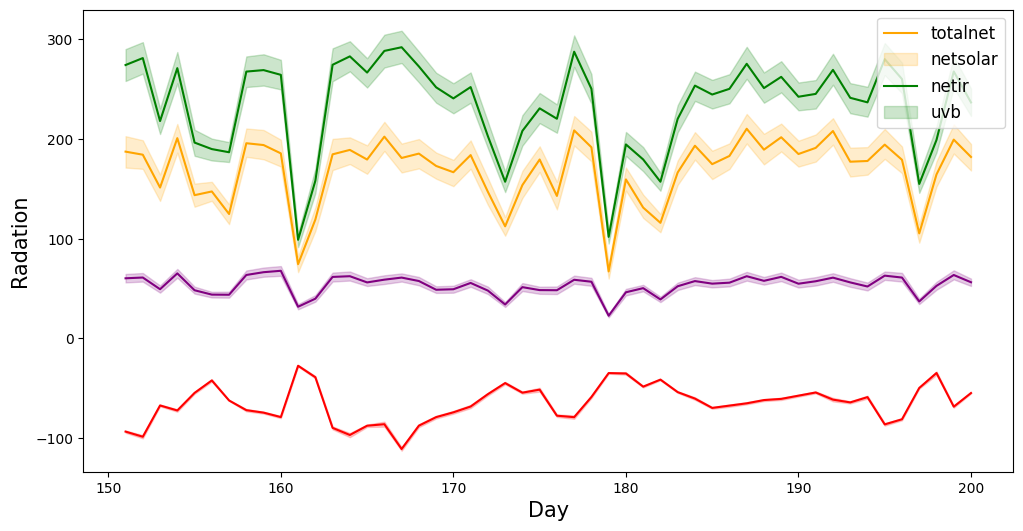

In [132]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='jday', y='totalnet', color='orange')
sns.lineplot(data=df, x='jday', y='netsolar', color='green')
sns.lineplot(data=df, x='jday', y='netir', color='red')
sns.lineplot(data=df, x='jday', y='uvb', color='purple')             

plt.xlabel('Day', fontsize=15)
plt.ylabel('Radation', fontsize=15)
plt.legend(['totalnet', 'netsolar', 'netir', 'uvb'], fontsize=12)
# plt.title('Total Solar Radiation for Julian day 1 of 2020', fontsize=20)
plt.show();

In [133]:
df_avg = df.groupby('hour').mean()

In [137]:
df_avg = df_avg.set_index(df_avg.index.astype(int)).sort_index()

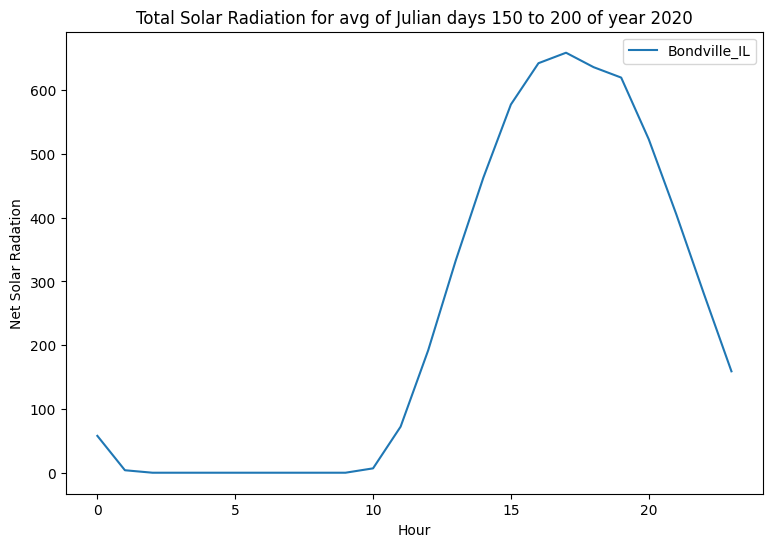

In [141]:
# plt.style.use("darkgrid")
plt.figure(figsize=(9,6))
sns.lineplot(data=df_avg, x=df_avg.index, y='netsolar', hue=None, style=None)
plt.xlabel('Hour')
plt.ylabel('Net Solar Radation')
plt.legend(locations)
plt.title('Total Solar Radiation for avg of Julian days 150 to 200 of year 2020')
plt.show();

### Plot of netsolar from surfrad data Bondville_IL 2020

In [148]:
df_avg.to_csv("../data/solar_data_Bondville_IL_avg_150_to_200_2020.csv")

In [150]:
df = pd.read_csv("../data/solar_data_Bondville_IL_avg_150_to_200_2020.csv", index_col=0)
df.head()

,jday,solar_zenith,ghi,uw_solar,dni,dhi,dw_ir,uw_ir,uvb,par,netsolar,netir,totalnet,temp_air,relative_humidity,pressure
hour,,,,,,,,,,,,,,,,
0,175.5,81.457480,71.915067,22.409533,222.490800,43.445933,384.332382,442.701700,3.340867,33.074658,57.806833,-58.451125,-0.605072,26.196067,54.172967,989.059167
1,175.5,91.587077,3.376500,1.180400,13.851100,4.463067,377.614228,428.704900,0.182733,2.259805,3.883000,-51.245812,-47.356139,24.816300,60.186533,989.309467
2,175.5,100.863160,-1.611933,-0.241533,0.027800,-0.366467,373.718167,422.113700,0.000000,0.000000,0.000000,-48.405633,-48.405633,23.685933,64.268433,989.754733
3,175.5,108.454363,-1.668767,-0.210667,0.034667,-0.380367,370.004900,417.817067,0.000000,0.000000,0.000000,-47.817333,-47.817333,22.746900,67.553233,990.108167
4,175.5,113.958180,-1.613767,-0.231300,0.040033,-0.350433,368.486567,415.082667,0.000000,0.000000,0.000000,-46.597133,-46.597133,22.034067,70.015867,990.224667


In [151]:
df.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='hour')

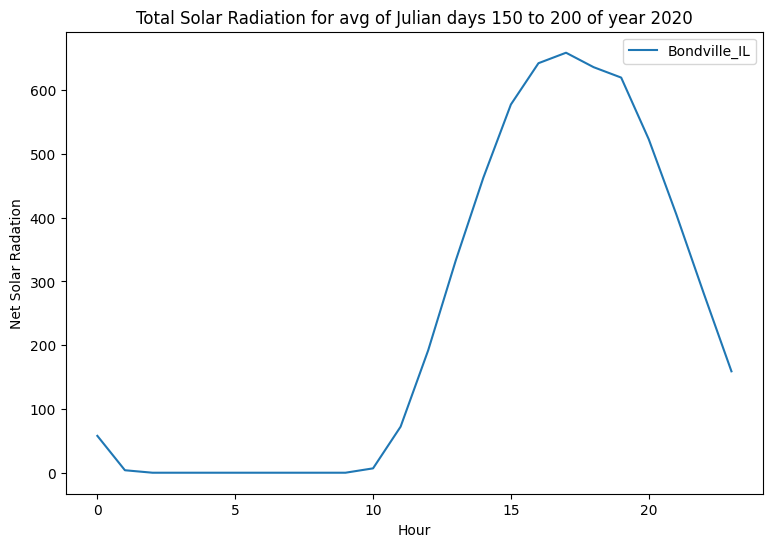

In [152]:
# plt.style.use("darkgrid")
plt.figure(figsize=(9,6))
sns.lineplot(data=df, x=df.index, y='netsolar', hue=None, style=None)
plt.xlabel('Hour')
plt.ylabel('Net Solar Radation')
plt.legend(locations)
plt.title('Total Solar Radiation for avg of Julian days 150 to 200 of year 2020')
plt.show();